In [63]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns

# Reading and normalizing data

In [64]:
data = pd.read_csv("data/train.csv")
# data = shuffle(data)
names = data["Name"]
ids = data["PassengerId"]
data = data.drop(["Name", "PassengerId"], axis = 1)
data["Sex"] = data["Sex"].map({"male": 1, "female": 0})
data["Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2})
# data = data.drop(["Cabin", "Ticket"], axis = 1)
data = data.fillna(-1)
# data = data.dropna()

In [65]:
# data = pd.get_dummies(data)
# data = shuffle(data)
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,A/5 21171,7.2500,-1,0.0
1,1,1,0,38.0,1,0,PC 17599,71.2833,C85,1.0
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,-1,0.0
3,1,1,0,35.0,1,0,113803,53.1000,C123,0.0
4,0,3,1,35.0,0,0,373450,8.0500,-1,0.0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,211536,13.0000,-1,0.0
887,1,1,0,19.0,0,0,112053,30.0000,B42,0.0
888,0,3,0,-1.0,1,2,W./C. 6607,23.4500,-1,0.0
889,1,1,1,26.0,0,0,111369,30.0000,C148,1.0


## Normalizing ticket

In [66]:
def normalize_ticket(word):
    if word == "LINE":
        return -1
    word = word.split()[-1]
    word = int(word)
    return word

for i, elem in enumerate(data["Ticket"]):
    data.loc[i, "Ticket"] = normalize_ticket(elem)

In [67]:
# for elem in data["Ticket"]:
#     print(elem)

## Normalizing cabin

In [68]:
from string import ascii_uppercase as alphabet
alphabet = list(alphabet)

def normalize_cabin(word):
    if word == -1:
        return -1
    word = word.split()
    result = []
    for w in word:
        elem = str(alphabet.index(w[0])) + w[1:]
        result.append(int(elem))
#     return ' '.join(result)
    return np.mean(result)
    
words = ["E101", "B57 B59 B63 B66"]
for word in words:
    print(normalize_cabin(word))

4101.0
161.25


In [69]:
for i, elem in enumerate(data["Cabin"]):
    data.loc[i, "Cabin"] = normalize_cabin(elem)
data["Cabin"] = data["Cabin"].astype("float64")

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null int64
Fare        891 non-null float64
Cabin       891 non-null float64
Embarked    891 non-null float64
dtypes: float64(4), int64(6)
memory usage: 69.7 KB


In [17]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,21171,7.2500,-1.0,0.0
1,1,1,0,38.0,1,0,17599,71.2833,285.0,1.0
2,1,3,0,26.0,0,0,3101282,7.9250,-1.0,0.0
3,1,1,0,35.0,1,0,113803,53.1000,2123.0,0.0
4,0,3,1,35.0,0,0,373450,8.0500,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,211536,13.0000,-1.0,0.0
887,1,1,0,19.0,0,0,112053,30.0000,142.0,0.0
888,0,3,0,-1.0,1,2,6607,23.4500,-1.0,0.0
889,1,1,1,26.0,0,0,111369,30.0000,2148.0,1.0


### Few data

In [18]:
y = data["Survived"]
data = data.drop("Survived", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.20, random_state = 11)

# Logistic Regression

## Logistic Regression without scaling

In [28]:
logit = LogisticRegressionCV(Cs = [10, 1, 0.1, 0.01, 0.001], class_weight = "balanced", tol = 0, max_iter = 150, \
                             solver = "lbfgs", random_state = 11, verbose = True, n_jobs = -1)

In [29]:
cross_val_score(logit, X_train, y_train, cv = 7)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

array([0.7254902 , 0.64705882, 0.68627451, 0.64705882, 0.76470588,
       0.65346535, 0.67326733])

In [21]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


LogisticRegressionCV(Cs=[10, 1, 0.1, 0.01, 0.001], class_weight='balanced',
                     cv=None, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=100,
                     multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=11, refit=True, scoring=None, solver='lbfgs',
                     tol=0.0001, verbose=True)

In [22]:
logit.C_

array([10.])

In [23]:
accuracy_score(logit.predict(X_train), y_train)

0.6334269662921348

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(logit.predict(X_test), y_test)

0.7902097902097902

### Let's have a look at the feature importane

In [33]:
pd.DataFrame({"feature": X_train.columns,
             "coef": 
              logit.coef_.flatten()}).sort_values(by = "coef", ascending = False)

,feature,coef
6,Embarked,0.226681
4,Parch,0.041189
5,Fare,0.005615
2,Age,-0.033739
3,SibSp,-0.321882
0,Pclass,-0.928967
1,Sex,-1.599680


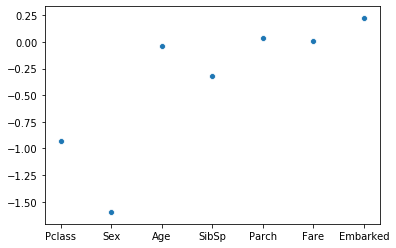

In [34]:
sns.scatterplot(X_train.columns, logit.coef_.flatten());

## Logistic Regression with scaling

In [30]:
from sklearn.linear_model import LogisticRegressionCV
logit_scaled = LogisticRegressionCV(Cs = [1, 0.1, 0.01, 0.001], class_weight = "balanced", solver = "lbfgs", \
                                    random_state = 11, verbose = True, n_jobs = -1)

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
cross_val_score(logit_scaled, X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

array([0.77622378, 0.78321678, 0.78169014, 0.78169014, 0.71126761])

In [32]:
logit_scaled.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


LogisticRegressionCV(Cs=[1, 0.1, 0.01, 0.001], class_weight='balanced', cv=None,
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=11, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=True)

In [33]:
accuracy_score(logit_scaled.predict(X_train_scaled), y_train)

0.7682584269662921

In [34]:
accuracy_score(logit_scaled.predict(X_test_scaled), y_test)

0.8212290502793296

### Let's have a look at the feature importane

In [35]:
pd.DataFrame({"feature": X_train.columns,
             "coef": logit_scaled.coef_.flatten()}).sort_values(by = "coef", ascending = False)

,feature,coef
5,Ticket,0.159388
7,Cabin,0.158824
6,Fare,0.087353
8,Embarked,0.049018
4,Parch,0.023181
2,Age,-0.309672
3,SibSp,-0.315760
0,Pclass,-0.816596
1,Sex,-1.186193


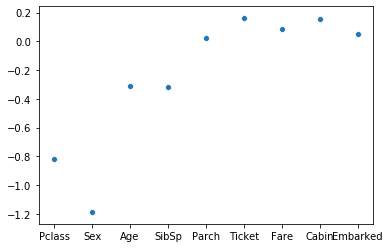

In [36]:
sns.scatterplot(X_train.columns, logit_scaled.coef_.flatten());

# Random Forest

In [46]:
rf = RandomForestClassifier(n_estimators = 321, random_state = 11, verbose = True)

In [47]:
params = {
    "max_depth": np.arange(5, 12),
#     "min_samples_split": np.arange(5, 12),
    "oob_score": [True, False]
}
best_rf = GridSearchCV(rf, params, n_jobs = -1, verbose = 2)

In [48]:
cross_val_score(best_rf, X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   13.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   13.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    0.0s finished


array([0.76923077, 0.83216783, 0.81690141, 0.83802817, 0.79577465])

In [49]:
best_rf.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    0.7s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=321, n_jobs=None,
                                              oob_score=False, random_state=11,
                               

In [50]:
best_rf.best_params_

{'max_depth': 10, 'oob_score': True}

In [51]:
accuracy_score(best_rf.predict(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    0.0s finished


0.9691011235955056

In [52]:
accuracy_score(best_rf.predict(X_test), y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 321 out of 321 | elapsed:    0.0s finished


0.8770949720670391

### Let's have a look at the feature importane

In [53]:
importance = pd.DataFrame({"col": X_train.columns,
             "coef": best_rf.best_estimator_.feature_importances_}).sort_values(by = "coef", ascending = False);

In [54]:
importance

,col,coef
1,Sex,0.260118
5,Ticket,0.195495
6,Fare,0.171767
2,Age,0.134115
0,Pclass,0.075165
7,Cabin,0.066073
3,SibSp,0.041750
4,Parch,0.031469
8,Embarked,0.024048


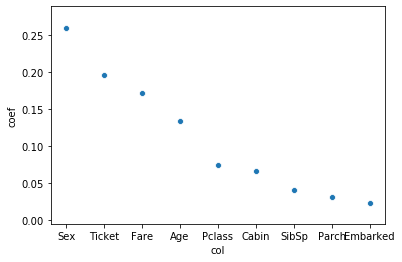

In [55]:
sns.scatterplot(importance["col"], importance["coef"]);

## As I mentioned in the Analysis, Sex, Fare and Age are very important features

# Finally, Logistic Regression is the best model of classification this data (TSNE gave a hint). Scaling is needed.

###############################################################

# XGBClassifier

In [56]:
import xgboost as xgb
# bst = xgb.XGBClassifier(max_depth = 9, learning_rate = 1e-3, booster = "gbtree", n_jobs = -1)
bst = xgb.XGBClassifier(n_jobs = -1, silent = False, n_estimators = 301)
params = {
#     "reg_alpha": [0.1, 0.2, 0.3, 0.4],
#     "scale_pos_weight": [1, 0.5, 0.1],
    "max_depth": np.arange(2, 6),
    "learning_rate": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    "booster": ["gbtree", "gblinear", "dart"]
}

bst = GridSearchCV(bst, params, n_jobs = -1, verbose = 5)

In [57]:
cross_val_score(bst, X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   20.3s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   25.6s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.9s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.6s finished


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   29.1s finished


array([0.74125874, 0.84615385, 0.83802817, 0.83802817, 0.77464789])

In [58]:
bst.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   34.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     reg_lambda=None, scale_pos_weight=None,
                                     silent=False, subsample=None,
                                     tree_method=None,
                                     validate_parameters=False,
                    

In [59]:
bst.best_params_

{'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 4}

In [60]:
accuracy_score(bst.predict(X_train), y_train)

0.8665730337078652

In [61]:
accuracy_score(bst.predict(X_test), y_test)

0.88268156424581

## Writing boosting and Random Forest to files

In [62]:
import pickle
models = {
    "rf.sav": best_rf,
    "xgb.sav": bst
}
for model in models:
    pickle.dump(models[model], open(model, "wb"))